In [1]:
from functools import partial
import time

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt

from swimpde.ansatz import BoundaryCompliantAnsatz
from swimpde.boundary import Periodic
from swimpde.domain import Domain
from swimpde.equation import EulerBernoulli
from swimpde.solver import TimeDependentSolver

from utils import compute_metrics, plot_results

Parameters of the equation

In [2]:
def intial_condition(x: npt.ArrayLike) -> npt.ArrayLike:
    return np.sin(x)

def initial_velocity(x: npt.ArrayLike) -> npt.ArrayLike:
    return np.zeros((x.shape[0], 1))

def forcing(x: npt.ArrayLike, t: float) -> npt.ArrayLike:
    return (1.0 - 16 * np.pi**2) * np.sin(x) * np.cos(4 * np.pi * t)

def solution(x: npt.ArrayLike, t: float) -> npt.ArrayLike:
    return np.sin(x) * np.cos(4 * np.pi * t)

boundary_condition = Periodic()

x_span = 0, np.pi
t_span = 0, 1

Create data for evaluation

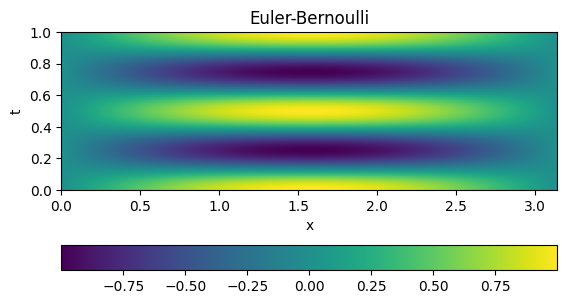

In [3]:
n_x_eval = 256
n_t_eval = 100


x_eval = np.linspace(*x_span, n_x_eval)[:, None]
t_eval = np.linspace(*t_span, n_t_eval)
u_exact = solution(x_eval, t_eval)

# Visualize the solution.
fig, ax = plt.subplots(1)
im = ax.imshow(u_exact.T, extent=[*x_span, *t_span], origin="lower")
fig.colorbar(im, ax=ax, orientation="horizontal");
ax.set_title("Euler-Bernoulli")
ax.set_xlabel("x")
ax.set_ylabel("t");

Create a domain

In [4]:
n_domain_points = 400
x_space = np.linspace(*x_span, n_domain_points)[:, None]

x_interior = x_space[1:-1]
x_boundary = x_space[[0, -1]]
domain = Domain(interior_points=x_interior,
                boundary_points=x_boundary)

Solve the equation

In [5]:
# Parameters of the solver 
n_basis = 10
n_inner_basis = 200
activation = "tanh"
random_seed = 42
regularization_scale = 1e-12
rtol = 1e-10
atol = 1e-10

In [6]:
# A target for the basis functions.
def periodic_target_fn(x, n_basis):
    scales = np.arange(1, n_basis + 1)
    sin_transforms = np.sin(x * scales)
    return sin_transforms


# Define the ansatz.
ansatz = BoundaryCompliantAnsatz(
    n_basis=n_basis,
    n_inner_basis=n_inner_basis,
    activation=activation,
    random_seed=random_seed,
    target_fn=partial(periodic_target_fn, n_basis=n_basis),
    boundary_condition=boundary_condition,
    regularization_scale=regularization_scale,
)


# Define the equation.
equation = EulerBernoulli(u0=intial_condition, ut0=initial_velocity)


# Define the solver.
solver = TimeDependentSolver(
    domain=domain,
    ansatz=ansatz,
    forcing=forcing,
    equation=equation,
    regularization_scale=regularization_scale,
    rtol=rtol,
    atol=atol,
)

# Fit the solver.
start_fit = time.time()
solver.fit(t_span=t_span)
end_fit = time.time()
training_time = end_fit - start_fit

print(f"Training time: {training_time:.4f}s")


Training time: 0.2067s


Evaluate the solver

Relative error: 3.484E-07


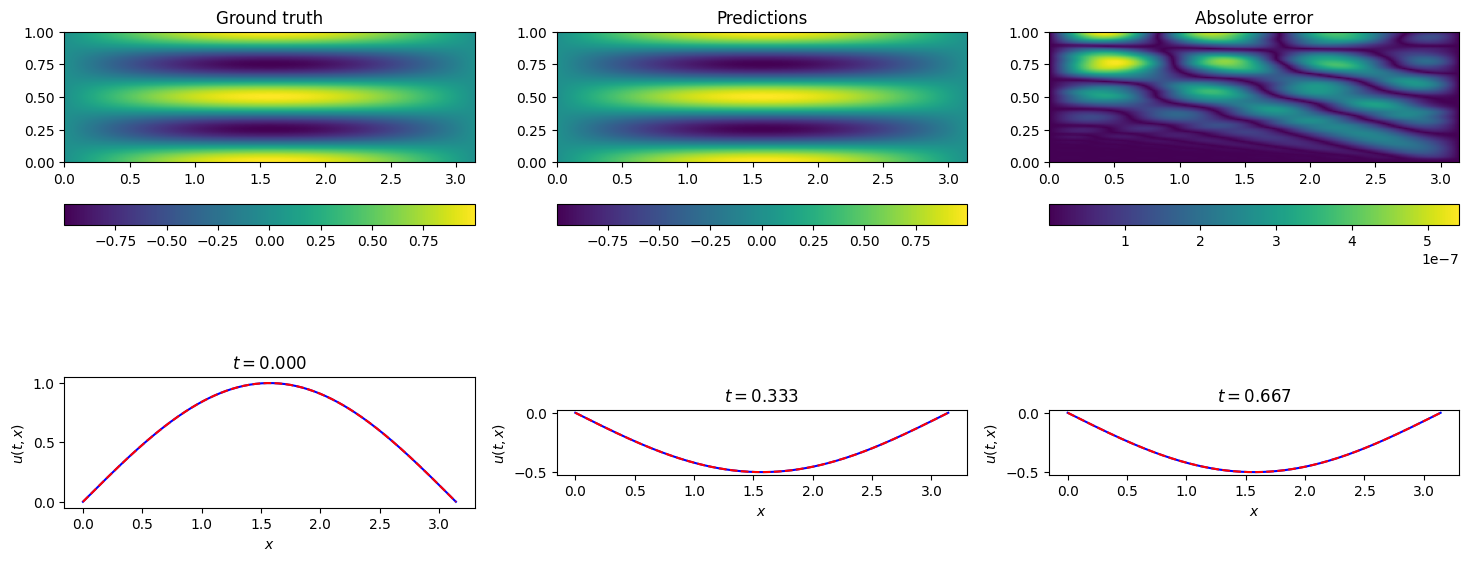

In [7]:
u_pred = solver.evaluate(x_eval, t_eval)
abs_error, rel_l2_error = compute_metrics(u_pred, u_exact)

print(fr"Relative error: {rel_l2_error:.3E}")
fig = plot_results(x_eval, t_eval, u_exact, u_pred, abs_error)